In [1]:
from openpiv import tools, pyprocess, validation, filters, scaling 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import imageio

/home/anna/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# data from run 2, trigger 20 [s], wave maker amplitude 0.1 [V], f = 2[Hz]


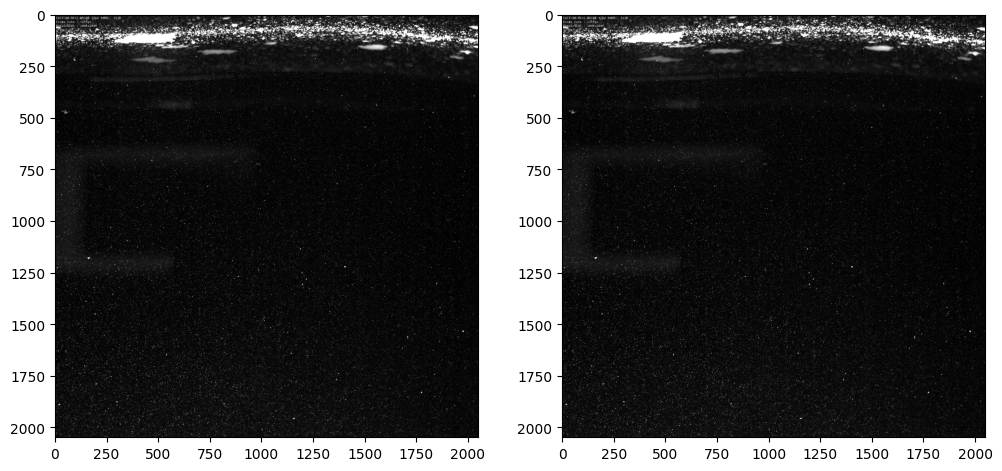

In [2]:
frame_a  = tools.imread( '/home/anna/annaCode/MEK4600/r2/192.168.0.100003.bmp')
frame_b  = tools.imread( '/home/anna/annaCode/MEK4600/r2/192.168.0.100005.bmp')
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
_ = ax[1].imshow(frame_b,cmap=plt.cm.gray)

In [3]:
(1/125)

0.008

CPU times: user 1.02 s, sys: 252 ms, total: 1.27 s
Wall time: 1.27 s


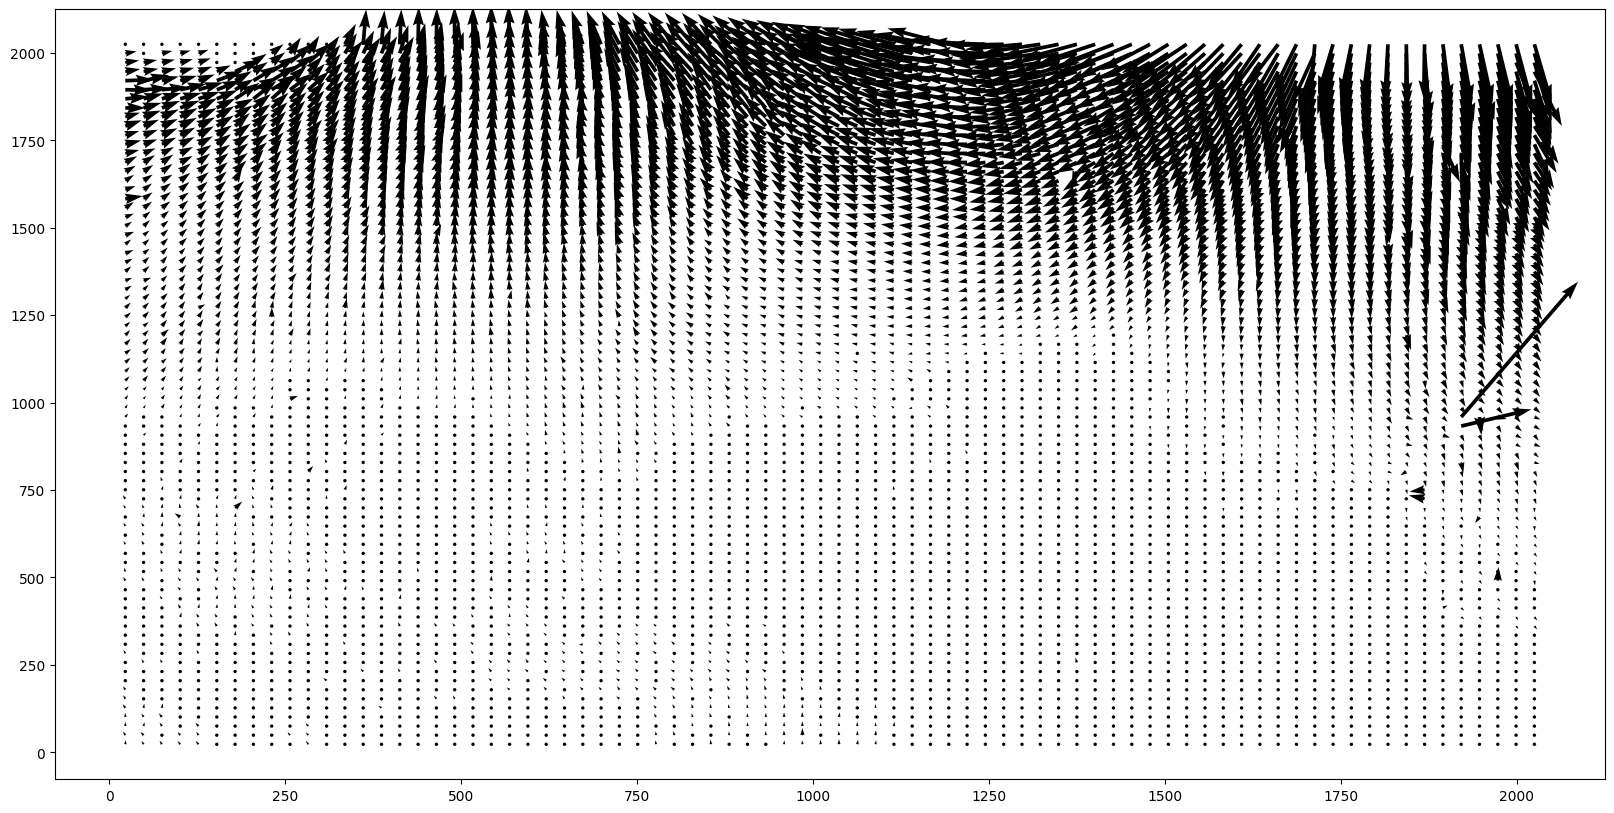

In [4]:
%%time
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 3* 0.008 # sec, time interval between pulses
dt = 2*(1/125) # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )
flags = validation.sig2noise_val( sig2noise, 
                                 threshold = 1.5 )
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u0, v0, 
                                   flags,
                                   method='localmean', 
                                   max_iter=3, 
                                   kernel_size=3)

xt, yt, ut, vt = tools.transform_coordinates(x, y, u2, v2)
plt.figure(figsize=(20, 10))
quiver = plt.quiver(xt, yt, ut, vt)

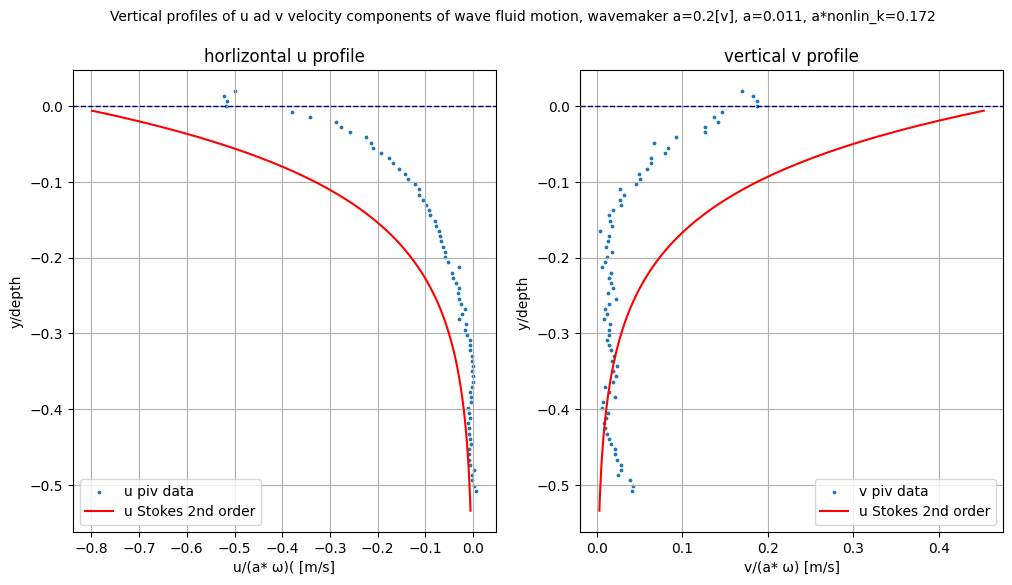

In [7]:

scale_factor = 2048 /0.324 # pixels/meter
shift_from_top_border= 100 /scale_factor # since 0 is not water level but border level, approx 100 pixels?
u3 = u2/scale_factor
xs =  x/scale_factor
ys =  -y/scale_factor

amplitude = 0.011
omega = 12.57
k_linear = 16.106
k_nonlinear = 15.615653691343352

water_depth = 0.6
column = 40

factor = (amplitude * omega / (1 + k_nonlinear**2*amplitude**2))*np.exp(k_nonlinear*ys) 
trig_arg = k_nonlinear * xs

u_stokes = factor * np.cos(trig_arg)
v_stokes = factor * np.sin(trig_arg)
#-----------------------------------------------
shift = 100  * scale_factor


fig,ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle(f'Vertical profiles of u ad v velocity components of wave fluid motion, wavemaker a=0.2[v], a={round(amplitude,3)}, a*nonlin_k={round(amplitude*k_nonlinear,3)}', fontsize=10)
ax[0].axhline(y=0, color='navy', linestyle='--', linewidth=1)
ax[0].scatter((u3[:,column]/(amplitude*omega)),  (ys[:,column]+shift_from_top_border)/water_depth , s = 3, label = 'u piv data')
ax[0].plot(u_stokes[:,column]/(amplitude*omega), ys[:,column]/water_depth, color = 'red', label = 'u Stokes 2nd order')
ax[0].legend()

#ax[0].scatter(u2[:,column]/(ampltidude*omega),  (y[:,column] + shift)/h, s = 3)
ax[0].set_title("horlizontal u profile")
ax[0].set_ylabel("y/depth")
ax[0].set_xlabel("u/(a* ω)( [m/s]")
ax[0].grid()

v3 = v2/scale_factor
ax[1].axhline(y=0, color='navy', linestyle='--', linewidth=1)
ax[1].scatter(v3[:,column]/(amplitude*omega), (ys[:,column] + shift_from_top_border)/water_depth, s = 3, label = 'v piv data')
ax[1].plot(v_stokes[:,column]/(amplitude*omega), ys[:,column]/water_depth, color = 'red', label = 'u Stokes 2nd order')
ax[1].grid()
ax[1].set_title("vertical v profile")
ax[1].set_ylabel("y/depth ")
ax[1].legend()
_ = ax[1].set_xlabel("v/(a* ω) [m/s]",)

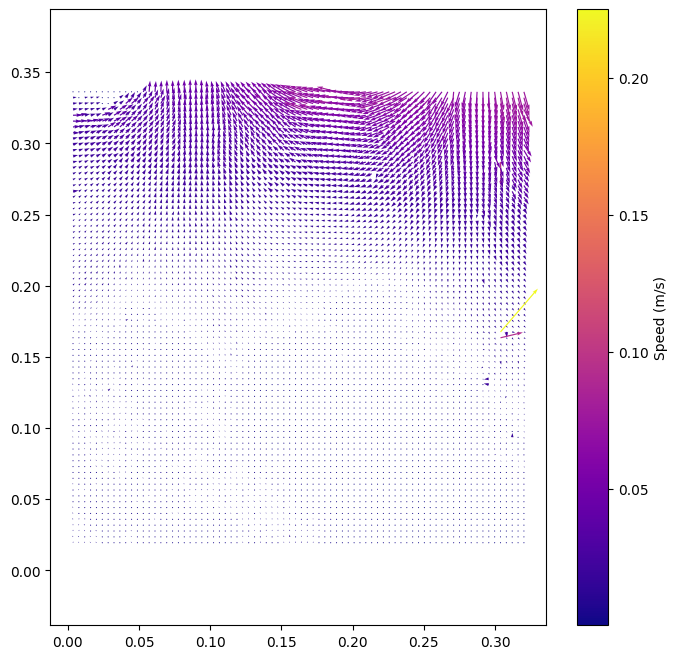

In [9]:
#scale_factor = 0.324316/2048
xs = xt/scale_factor
ys = yt/scale_factor
us = ut/scale_factor
vs = vt/scale_factor


#shift = 100  * scale_factor -0.324316 
speed = np.sqrt(us**2 + vs**2)

plt.figure(figsize=(8, 8))
plt.axis('equal')
quiver = plt.quiver(xs , ys + shift_from_top_border , us, vs, speed, cmap="plasma")
_ = plt.colorbar(quiver, label='Speed (m/s)')